# Mapping rasters

## Introduction

This Notebook is a re-implenentation of some of the maps relating to global livestock density, based upon the book Python Maps
Geospatial Visualization with Python, 
by Adam Symington [https://locatepress.com/book/pymaps]

This served as an introduction to `rasterio` for me.

## Implementation

### Include Magics
`watermark` provides reproducibility information, `lab_black` format the Python consistently

In [1]:
%matplotlib inline

In [2]:
%load_ext watermark

In [3]:
%load_ext lab_black

### Include packages

In [4]:
# all imports should go here

import pandas as pd
import numpy as np

import geopandas as gpd
import geodatasets as gds

from shapely.geometry import Point

import cartopy.crs as ccrs

import rasterio
from rasterio.plot import show

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
from matplotlib import colors
import matplotlib
from matplotlib.ticker import StrMethodFormatter

import cartopy.crs as ccrs

--------------------
## Load data

We load the data, and show the Coordinated Reference System used for the data: turns out to be just plain old Lat / Lon (PlateCarree)

In [5]:
CATTLE_URL = "C:\\Data\\PythonMaps\\Livestock\\GLW4-2020.D-DA.CTL.tif"


cattle = rasterio.open(CATTLE_URL)

print(
    cattle.crs,
)

EPSG:4326


Do a quick plot:  turns out that most pixels represent zero livestock, and having a linear color map makes it hard to see the few pixels that are non-zero.  Further below, we will define a colormap and normalization (mapping from datra tio color) that will improve this map.

Note also that the data encodes coastlines and oceans, in some way I don't understand, but `rasterio.plot.show()` fully understands.  Notice also that Antartica is missing (understandable). Note also that `raterio.plot.show` knows about Lat/ Lon, and labels the graph accordingly

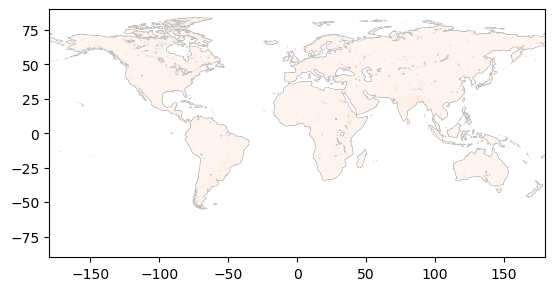

<Axes: >

In [6]:
show(cattle, cmap='Reds')

## A digression: load global borders

For later use, we load the Natural Earth country borders dataset

In [7]:
BORDERS_URL = "C:\\Data\\PythonMaps\\Borders\\borders\\ne_10m_admin_0_countries.shp"

borders = gpd.read_file(BORDERS_URL)

We exclude Antarticia

In [8]:
world = borders[borders['CONTINENT'] != 'Antarctica'].copy()

Plot world borders

<Axes: >

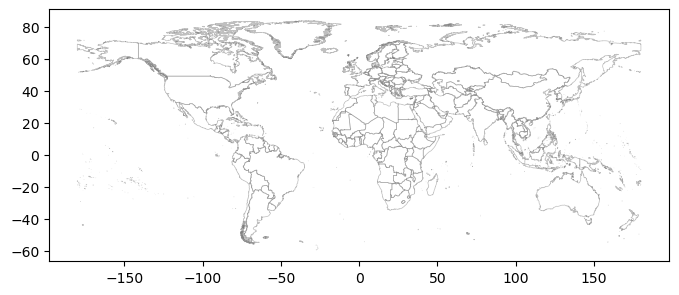

In [9]:
fig, ax = plt.subplots(
    figsize=(8, 8),
)

world.boundary.plot(
    ax=ax,
    color='gray',
    alpha=0.5,
    linewidth=0.5,
)

------------------------
## Construct a data to color mapping

We start by creating a quasi-log array of values (each roughly twice the previous).  The values I use are takn from a FAO web map. 

In [10]:
bounds = [
    5,
    10,
    20,
    50,
    100,
    250,
    5000,
]
#  matches FaO GLW3: Gridded Livestock Density - Global 2010 - 10 km) web map

Now build a colormap

We get a `matplotlib` colormap that maps values between 0 and 1 to a color ranging from white (0) to dark green (1)

In order not impose the task of interpreting the various shades of green  values:

* we create a linear array between 0 and 1 (inclusive), with as many values as in our `bounds` array
* we get an array of colors from our `greens`  color map, using the linear equally spaced array between 0 and 1 (inclusive)
* we create a new colormap (`cattle_cmap`), that maps a value between the lower bound and the upper bound into the one of the list of colors in `newcolors`
* finally, we create a normalization function (`cattle_norm`), that maps a data value into a color lookup value

In [11]:
greens = plt.get_cmap(
    'Greens',
    len(bounds),
)

# get len(bounds) colors from Greens colormap [greens(x) returns color where 0<x<1]
newcolors = greens(np.linspace(0, 1, len(bounds)))

# make a new color map based upon list [len(bounds) ] of  colors selected from  built-in color map
cattle_cmap = ListedColormap(newcolors)

# function to map value (here= cattle density) to integer for lookup of color
cattle_norm = colors.BoundaryNorm(
    bounds,
    cattle_cmap.N,
)

-------------
### Initial plot
We use `rasterio.plot.show()` to do a quick and easy plot.  Just to recap, 
* `cattle_norm` takes a data value and turns it into an integer
* `cattle_cmap` returns a color, given an integer

Our dataset set gives us coastlines, but not country borders

<Axes: >

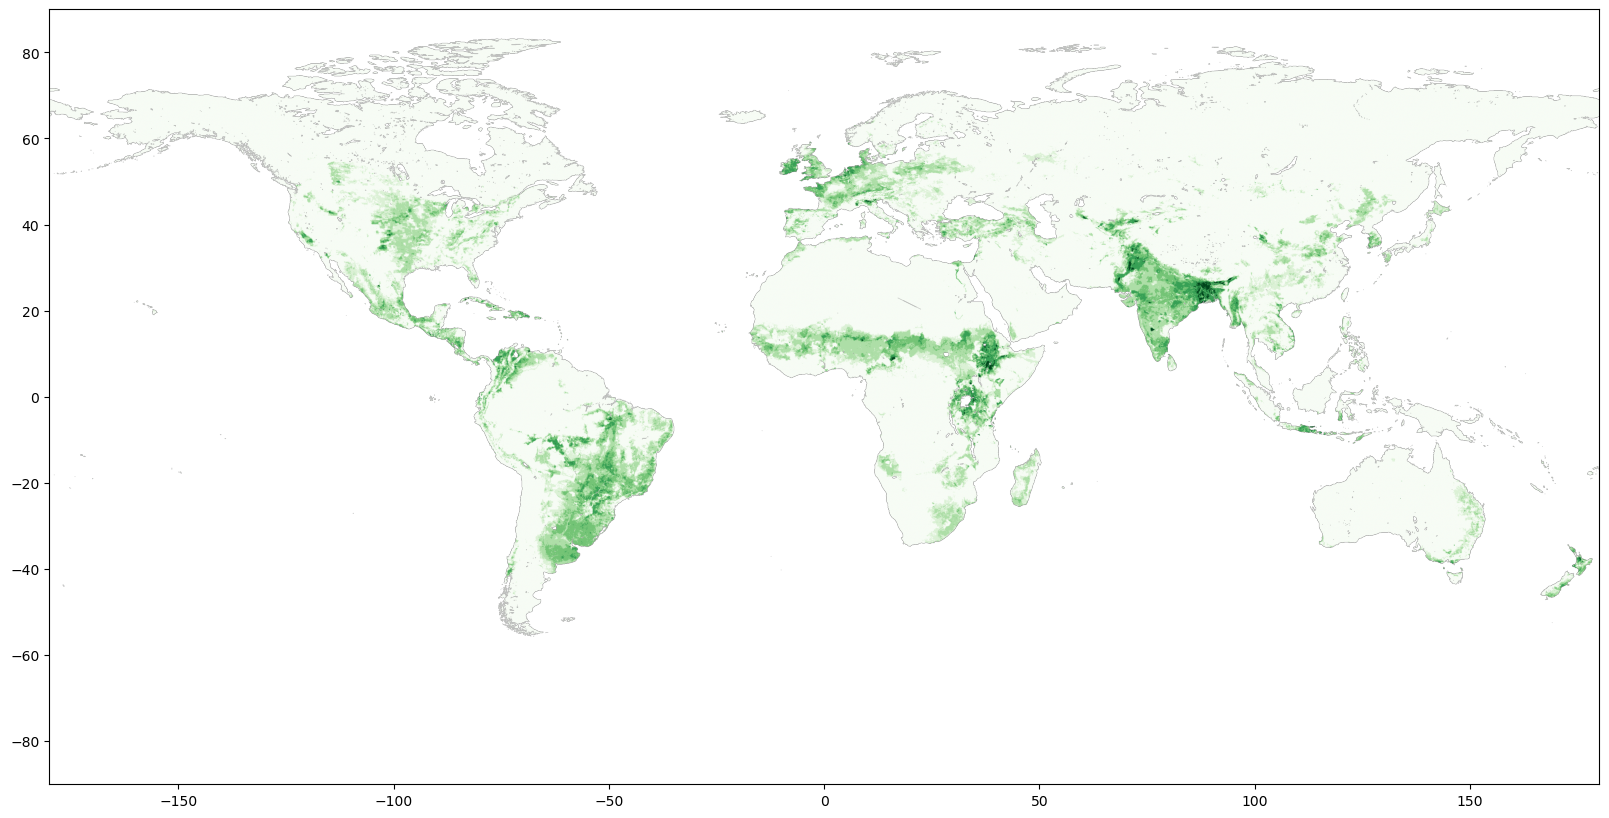

In [12]:
fig, ax = plt.subplots(
    figsize=(20, 20),
)

show(
    cattle,
    ax=ax,
    cmap=cattle_cmap,
    norm=cattle_norm,
    alpha=1,
)

-------------------
### Add colorbar

In the next map, we add in the global country boundaries.  I have copied the code from the book, to add a colorbar / legend that is highly customized.  You will note that the code to draw the customized colorbar is much larger than that used to map the data.  This illustrates both the power of `matplotlib` (you can do almost any customization you want), and the downside (to customize any aspect of a graphic, usually requires knowledge of the deep object structure of `matplotlib`)

Below I will give a shorter way of generating a colorbar.  

Note also the lines:

```cb = fig.colorbar(
    plt.cm.ScalarMappable(
        cmap=cattle_cmap, norm=cattle_norm
    ),
```
Usually, the `colorbar` mehod is handed an image to to be used to construct the colorbar.  But ...

> A colorbar needs a "mappable" (matplotlib.cm.ScalarMappable) object (typically, an image) which indicates the colormap and the norm to be used. In order to create a colorbar without an attached image, one can instead use a ScalarMappable with no associated data.

It could be that the `rasterio.plot.show` method doesn't return an object that can be used to generate a colorbar (it actually returns an `Axes` object)

Text(0.5, 0, 'Cattle Density')

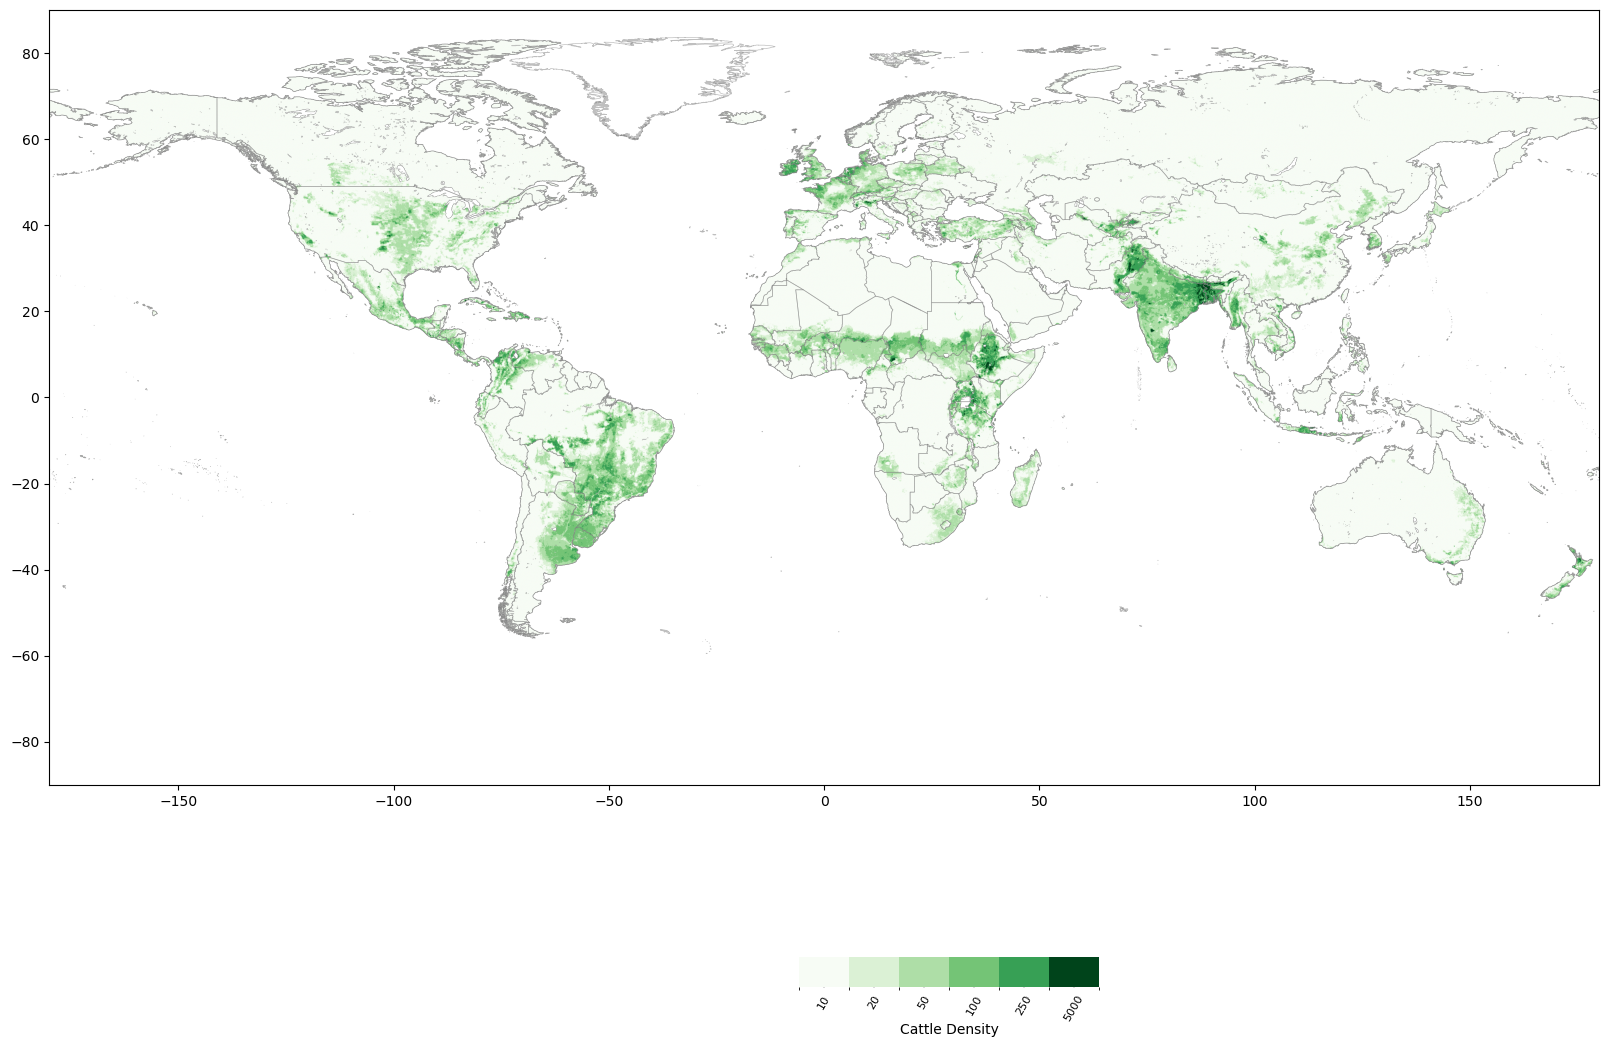

In [13]:
fig, ax = plt.subplots(
    figsize=(20, 20),
)

world.boundary.plot(
    ax=ax,
    color='gray',
    alpha=0.5,
    linewidth=0.5,
)

show(
    cattle,
    ax=ax,
    cmap=cattle_cmap,
    norm=cattle_norm,
    alpha=1,
)


cax = fig.add_axes([0.5, 0.2, 0.15, 0.015])

# position color bar block label in  middle of color block
cb_ticks = [
    bounds[i] + (bounds[i + 1] - bounds[i]) / 2
    for i in range(len(bounds) - 1)
]
cb = fig.colorbar(
    plt.cm.ScalarMappable(
        cmap=cattle_cmap, norm=cattle_norm
    ),
    cax=cax,
    orientation="horizontal",
    pad=0,
    format='%.3g',
    ticks=cb_ticks,
    drawedges=False,
)
cb.ax.set_xticklabels([str(val) for val in bounds[1:]])
cb.outline.set_visible(False)
cb.ax.tick_params(
    labelsize=8,
    width=0.2,
    length=0.75,
    rotation=60,
    color='black',
)
cb.ax.set_xlabel(
    f'Cattle Density',
    fontsize=10,
    color='black',
    labelpad=0,
)

-----------------------
## Using `imshow` 

This section shows how to create similar graphics with `matplotlib` only (using `rasterio` for data load only).

Read the data into a `numpy` array.  The `read` method reads the first band of the TIF image (we have only one band).

In [14]:
array = cattle.read(1)

Display data range

In [15]:
array.max(), array.min()

(3654.1978, -3.4028235e+38)

We use the same  color maps as before, but here we convert the `rasterio` missing data value into a `numpy` Nan.  We also specify the color we want to use for pixels with missing or ill-defined data 

`imshow`gives us a very similar image as before (but note axes are in pixel count, not Lat/ Lon)

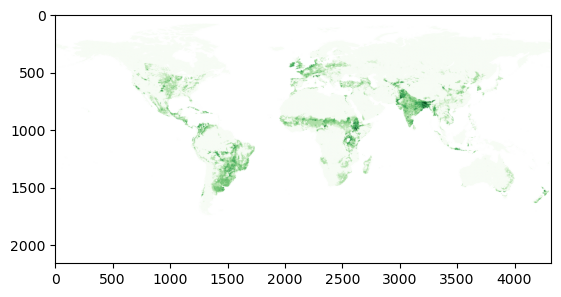

In [16]:
cattle_cmap.set_bad(color='white')

array[array == (cattle.nodata)] = np.nan

plt.imshow(
    array,
    cmap=cattle_cmap,
    norm=cattle_norm,
)

---------------------
## Use log normalization, and `imshow`

So, putting it all together:

* create a figure and Axes object using Cartopy
* plot the world borders
* create a logarithmetic normalization for the range as before (5, 5000)
* create a colormap using the standard for showing terrain (hoping viewers will use prior knowledge of terrain maps to get a feel for variations in cattle distribution)
* use imshow to show the data as an image
* draw lines of latitude only (cattle distribution should only be affected by latitude, not longtitude)
* draw a colorbar (with integer labels)

Note the code to draw a colorbar, and to set up colormaps and normalization, is much smaller that in the code from the book.  I will let the 

Text(0.5, 0, 'Cattle density\n(head/km^2')

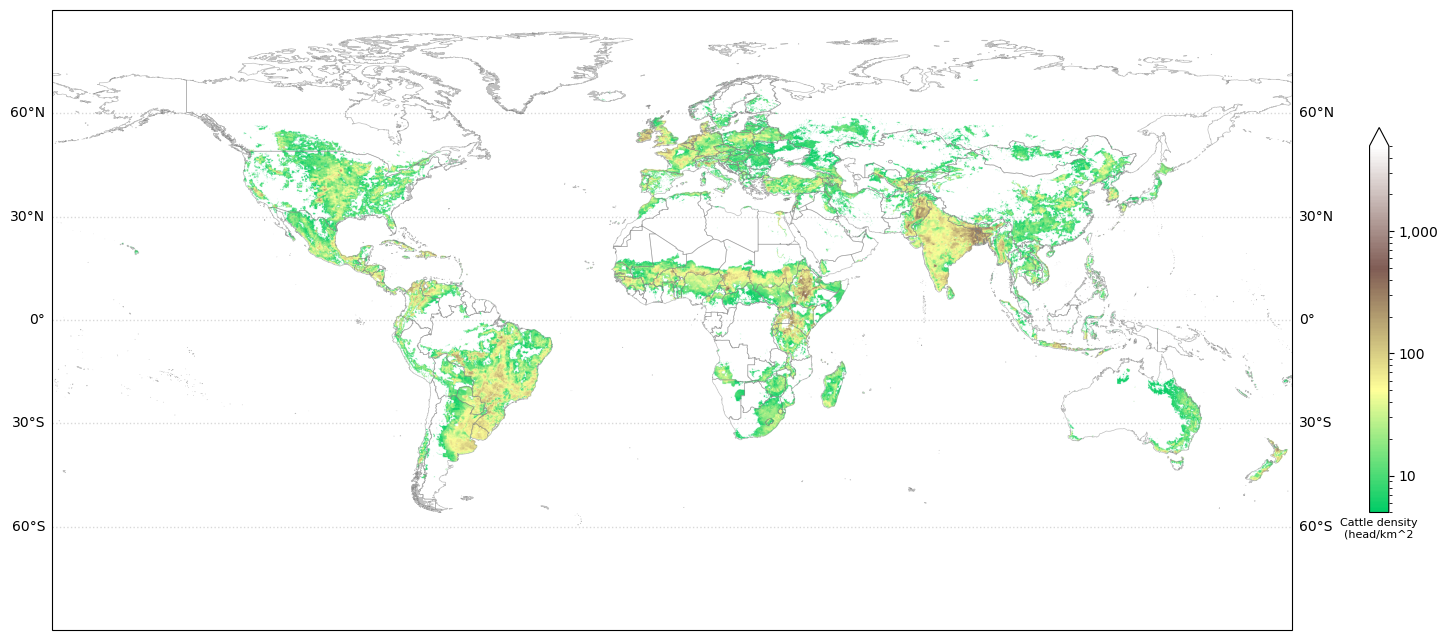

In [17]:
fig, ax = plt.subplots(
    figsize=(20, 20),
    subplot_kw={'projection': ccrs.PlateCarree()},
)

# plot the world borders
world.boundary.plot(
    ax=ax,
    color='gray',
    alpha=0.5,
    linewidth=0.5,
)

# create a logarithmic normalization for the range 5 to 5000
lognorm = colors.LogNorm(vmin=5, vmax=5000)

# create a color map using terrain, where bad or out-of-range data pixels are set to white
# we skip the underwater blue parts of the "terrain" colormap
colors_land = plt.cm.terrain(np.linspace(0.25, 1, 256))
my_cmap = colors.LinearSegmentedColormap.from_list(
    'land', colors_land
)
# my_cmap = matplotlib.colormaps['terrain']
my_cmap.set_bad('white')
my_cmap.set_under('white')


# tell imshow we cover -180 to 180 longitude -90 to 90 latitude
extent = (-180, 180, -90, 90)

# show the data array as an image
pcm = ax.imshow(
    array,
    cmap=my_cmap,
    norm=lognorm,
    extent=extent,
    transform=ccrs.PlateCarree(),
)

# draw latitude gridlines only
gl = ax.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels=True,
    linewidth=1,
    linestyle='dotted',
    color='gray',
    alpha=0.3,
)
gl.top_labels = False
gl.bottom_labels = False
gl.right_labels = True
gl.left_labels = True
gl.xlines = False

# draw a colorbar
cb = fig.colorbar(
    pcm,
    ax=ax,
    extend='max',
    shrink=0.25,
)
# have colorbad labels a integers (not powers)
cb.formatter = StrMethodFormatter('{x:,.0f}')
cb.ax.set_xlabel(
    'Cattle density\n(head/km^2',
    fontsize=8,
)

## Trap!: `imshow` with default colormap

Note one gotcha with `imshow`:  in datasets like that loaded by `rasterio`, some pixels have `bad` or missing data values.  If we just do a simple `imshow` call, theses generate spurious gray pixels

In [18]:
# clear figure and axes object variables
fig, ax = 0, 0

`imshow` with spurious pixels (look at the Sahara)

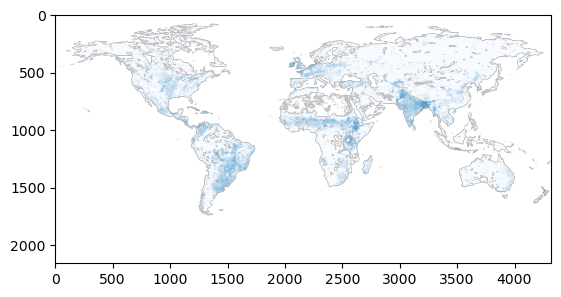

In [19]:
plt.imshow(
    array,
    cmap='Blues',
    norm=lognorm,
)

If we set the treatment of bad or missing data explicitly in our colormap, it looks a lot nicer!

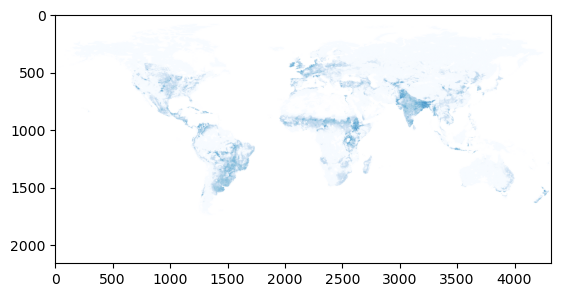

In [20]:
my_blue = matplotlib.colormaps['Blues']
my_blue.set_bad('white')

plt.imshow(
    array,
    cmap=my_blue,
    norm=lognorm,
)

## Reproducibility

In [21]:
%watermark

Last updated: 2025-05-09T11:49:14.599620+10:00

Python implementation: CPython
Python version       : 3.12.9
IPython version      : 9.0.2

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 11
Machine     : AMD64
Processor   : Intel64 Family 6 Model 170 Stepping 4, GenuineIntel
CPU cores   : 22
Architecture: 64bit



In [22]:
%watermark -h -iv

Hostname: INSPIRON16

rasterio   : 1.4.3
numpy      : 1.26.4
matplotlib : 3.10.0
pandas     : 2.2.3
shapely    : 2.0.6
geopandas  : 1.0.1
geodatasets: 2024.8.0
cartopy    : 0.24.1



In [23]:
%watermark -co

conda environment: pythonmaps

